In [1]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 82.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd
import numpy as np

In [5]:
# setting A
df_train = pd.read_csv('TR_a.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_a.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_a.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

In [6]:
df_train['QA'] = df_train['Main_tweet'] + '[SEP]' + df_train['Reply_tweet']
df_dev['QA'] = df_dev['Main_tweet'] + '[SEP]' + df_dev['Reply_tweet']
df_test['QA'] = df_test['Main_tweet'] + '[SEP]' + df_test['Reply_tweet']


In [7]:
df_test['gold'].value_counts()

y     212
n     157
uk     80
py     49
pn     29
Name: gold, dtype: int64

In [8]:
y = pd.get_dummies(df_train.gold, prefix='gold')
y

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
3310,0,0,1,0,0
3311,1,0,0,0,0
3312,1,0,0,0,0
3313,0,0,0,1,0


In [9]:
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_dev

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
595,1,0,0,0,0
596,0,0,1,0,0
597,0,0,0,1,0
598,0,0,1,0,0


Roberta Init

In [10]:
# Changed to roberta

bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [11]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
# l = tf.keras.layers.Dense(50, activation='sigmoid', name="output")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(l)

# # adding drop out layer
# l = tf.keras.layers.Dropout(0.2, name="dropout")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(l)

#use this if without dropout, instead of the two layers above
l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [13]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [14]:
df_circa = pd.read_excel(r'circa_train.xlsx')

df_twitter=pd.read_csv('TR_a.csv')

df_twitter=df_twitter.rename(columns={"gold_adj": "gold"})

In [15]:
df_circa.columns

Index(['Unnamed: 0', 'id', 'context', 'question-X', 'canquestion-X',
       'answer-Y', 'judgements', 'goldstandard1', 'goldstandard2'],
      dtype='object')

In [16]:
df_circa['goldstandard1'] = df_circa['goldstandard1'].replace(np.nan, 'N/A')
df_circa['goldstandard1'] = df_circa['goldstandard1'].astype(str)

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Yes, subject to some conditions', 'py')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Probably yes / sometimes yes','py')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Probably no','pn')

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('In the middle, neither yes nor no','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('I am not sure how X will interpret Y’s answer','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('N/A','uk')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Other','uk')

df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('No','n')
df_circa['goldstandard1'] = df_circa['goldstandard1'].str.replace('Yes','y')



In [17]:
# blend corpus
df_circa = df_circa.rename(columns={"goldstandard1": "gold"})
df_circa['QA'] = df_circa['question-X'] + '[SEP]' + df_circa['answer-Y']
df_circa = df_circa[['QA','gold']].copy()


df_circa = df_circa.rename(columns={"Goldstandard": "gold"})
df_circa['corpus_type'] = 'circa'

# main corpus
df_twitter['QA'] = df_twitter['Main_tweet'] + '[SEP]' + df_twitter['Reply_tweet']
df_twitter = df_twitter[['QA','gold']].copy()
df_twitter['corpus_type'] = 'twitter'

In [18]:
epochs = 200
val_loss = 100
patience = 0
alpha = 0.5
corpus_frac = 1 # initially
for e in range(epochs):

  df_train = pd.concat([df_twitter, df_circa.sample(frac = corpus_frac)])
  df_train = df_train.sample(frac = 1)
  y_train = pd.get_dummies(df_train.gold, prefix='gold')
  print(df_train.shape)
  print(y_train.shape)

  # shortening blending corpus for quick sanity results
  # df_train = df_train.iloc[0:100]
  # y_train = y_train.iloc[0:100]
  # df_dev = df_dev.iloc[0:100]
  # y_dev = y_dev.iloc[0:100]

  corpus_frac = alpha * corpus_frac

  model.fit(df_train['QA'], y_train, epochs=1, batch_size=16, callbacks=[callback], validation_data = (df_dev['QA'], y_dev))
  if model.history.history['val_loss'][0] - val_loss <= 0.01:
    val_loss = model.history.history['val_loss'][0]
    saved_model = model
    patience = 0
  else:
    patience +=1
  if patience == 5:
    print('breaking now.....')
    break
  print('patience:',patience)
  print('epoch:',e)

(23875, 3)
(23875, 5)
1493/1493 [==============================] - 1160s 766ms/step - loss: 0.7911 - accuracy: 0.7197 - precision: 0.8014 - recall: 0.6311 - lr: 2.0000e-05 - val_loss: 1.0655 - val_accuracy: 0.6167 - val_precision: 0.7032 - val_recall: 0.4817 - val_lr: 2.0000e-05
patience: 0
epoch: 0
(13595, 3)
(13595, 5)
850/850 [==============================] - 678s 798ms/step - loss: 0.6029 - accuracy: 0.7859 - precision: 0.8485 - recall: 0.7264 - lr: 2.0000e-05 - val_loss: 1.0590 - val_accuracy: 0.6417 - val_precision: 0.7304 - val_recall: 0.5600 - val_lr: 2.0000e-05
patience: 0
epoch: 1
(8455, 3)
(8455, 5)
529/529 [==============================] - 445s 842ms/step - loss: 0.5546 - accuracy: 0.8076 - precision: 0.8588 - recall: 0.7581 - lr: 2.0000e-05 - val_loss: 1.0686 - val_accuracy: 0.6233 - val_precision: 0.7126 - val_recall: 0.5167 - val_lr: 2.0000e-05
patience: 0
epoch: 2
(5885, 3)
(5885, 5)
368/368 [==============================] - 326s 887ms/step - loss: 0.4422 - accuracy:

Dev set

In [19]:
y_dev = pd.get_dummies(df_dev.gold, prefix = 'gold')
print(saved_model.evaluate(df_dev['QA'], y_dev))
y_predicted = saved_model.predict(df_dev['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 14s 740ms/step - loss: 2.0378 - accuracy: 0.6350 - precision: 0.6395 - recall: 0.6267 - lr: 2.0000e-05
[2.0377907752990723, 0.6349999904632568, 0.6394557952880859, 0.6266666650772095, 2.000000313273631e-05]
19/19 [==============================] - 14s 714ms/step
DEV
              precision    recall  f1-score   support

           n       0.65      0.65      0.65       166
          pn       0.28      0.26      0.27        19
          py       0.44      0.46      0.45        61
          uk       0.66      0.43      0.52       113
           y       0.68      0.79      0.73       241

    accuracy                           0.64       600
   macro avg       0.54      0.52      0.53       600
weighted avg       0.63      0.64      0.63       600



Test Set

In [20]:
df_test= df_test.rename(columns={"gold_adj": "gold"})
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(saved_model.evaluate(df_test['QA'], y_test))
y_predicted = saved_model.predict(df_test['QA'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n',
                                       'gold_pn',
                                       'gold_py',
                                       'gold_uk',
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n',
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 11s 669ms/step - loss: 1.9991 - accuracy: 0.6357 - precision: 0.6447 - recall: 0.6300 - lr: 2.0000e-05
[1.9990789890289307, 0.6356736421585083, 0.6446601748466492, 0.6299810409545898, 2.000000313273631e-05]
17/17 [==============================] - 11s 644ms/step
TEST
              precision    recall  f1-score   support

           n       0.65      0.76      0.70       157
          pn       0.21      0.10      0.14        29
          py       0.37      0.29      0.32        49
          uk       0.53      0.39      0.45        80
           y       0.72      0.79      0.76       212

    accuracy                           0.64       527
   macro avg       0.50      0.47      0.47       527
weighted avg       0.61      0.64      0.62       527



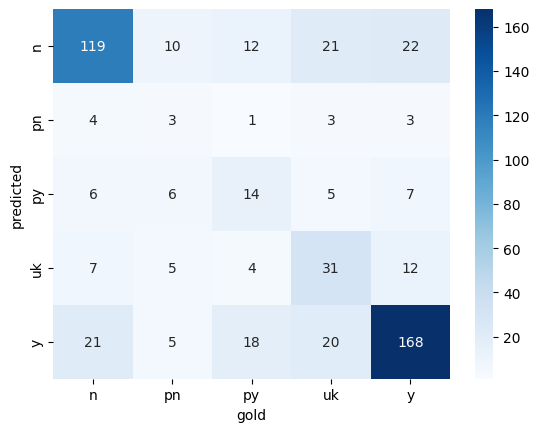

gold         n  pn  py  uk    y
predicted                      
n          119  10  12  21   22
pn           4   3   1   3    3
py           6   6  14   5    7
uk           7   5   4  31   12
y           21   5  18  20  168


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [22]:
pred_results = pred_results.rename(columns={"gold": "predict"})
pred_results['Main_Tweet_ID'] = df_test['Main_Tweet_ID']
pred_results['Reply_id'] = df_test['Reply_id']

In [23]:
pred_results['predict'].value_counts()

y     232
n     184
uk     59
py     38
pn     14
Name: predict, dtype: int64

In [24]:
pred_results.to_csv('/content/drive/MyDrive/expts_emnlp23/results/A_circa_blend.csv')